<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/4%20-%20Overfitting%20e%20Tecniche%20di%20Regolarizzazione/overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Riconoscere l'overfitting


In [2]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
RANDOM_SEED = 0 #per ottenere gli stessi risultati

In [4]:
from sklearn.model_selection import train_test_split

#un buon modo per avere overfitting è avere numero di esempi uguale al numero di esempi
X, y = make_regression(n_samples=100, n_features=100, n_informative=10, n_targets=1, bias=0.0, tail_strength=0.5, noise=50.0, random_state=RANDOM_SEED)
print(X.shape, y.shape)

(100, 100) (100,)


### Hold-out

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70, 100) (70,)
(30, 100) (30,)


In [6]:
ss = StandardScaler() #standardizziamo i dati
X_train = ss.fit_transform(X_train) 
X_test = ss.transform(X_test) #applichiamo la stessa trasformazione anche per i dati di test

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train) #addestriamo il modello

LinearRegression()

In [8]:
def evaluate_model(model, dataset):

  X, y = dataset

  y_pred = model.predict(X)

  print(f"MSE: {mean_squared_error(y, y_pred):.3f}")
  print(f"R2: {r2_score(y, y_pred):.3f}")

In [9]:
evaluate_model(lr, (X_train, y_train))

MSE: 0.000
R2: 1.000


Il modello sul set di train sembra essere perfetto.

Guardiamo invece come si comporta sul set di test che contiene dei dati che il modello non ha mai visto!

Il risultato è abbastanza scarso, quindi il modello sta soffreddo di Overfitting!

In [10]:
evaluate_model(lr, (X_test, y_test))

MSE: 17281.613
R2: 0.053


### Cross-validation

In [11]:
from sklearn.model_selection import  cross_validate, cross_val_score, KFold

In [14]:
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=5, scoring="r2")
scores

array([ 0.29720369,  0.32583144,  0.10896364,  0.08102096, -0.24933553])

In [15]:
scores.mean() #facciamo la media dei risultati

0.11273683864804576

In [16]:
lr = LinearRegression()
cv_results = cross_validate(lr, X, y, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.21175194, 0.02388263, 0.00422931, 0.00409007, 0.47001791]),
 'score_time': array([0.00178981, 0.00145316, 0.00121379, 0.00093699, 0.00138402]),
 'test_score': array([ 0.29720369,  0.32583144,  0.10896364,  0.08102096, -0.24933553]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [17]:
cv_results["train_score"].mean()

1.0

In [18]:
cv_results["test_score"].mean()

0.11273683864804576

In questo caso non abbiamo eseguito la standardizzazione dei dati perchè avremmo dovuto passare i dati che passiamo per l'addestramento batch per batch, all'interno dei metodi cross_validate o cross_val_score.


Questa cosa la possiamo fare grazie alla classe KFold che possiamo utilizzare per dividere il dataset in più batch.

Variante KFold Cross validation 

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
kf.get_n_splits(X)

5

In [21]:
train_score = []
test_score = []

for train_index, test_index in kf.split(X): #batch per batch
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = StandardScaler()   #qui eseguiamo la standardizzazione
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LinearRegression()
  lr.fit(X_train, y_train)

  r2_train = r2_score(y_train, lr.predict(X_train))
  train_score.append(r2_train)

  r2_test = r2_score(y_test, lr.predict(X_test))
  test_score.append(r2_test)

scores = {
      "train_score":np.array(train_score),
      "test_score":np.array(test_score)
    }

In [22]:
scores

{'train_score': array([1., 1., 1., 1., 1.]),
 'test_score': array([ 0.21975703, -0.26167678,  0.38474004,  0.30060749,  0.44474871])}

In [23]:
scores["train_score"].mean()

1.0

In [24]:
scores["test_score"].mean()

0.21763530056896413

### LOOCV

In questa variante eseguiamo l'addestramento su tutto il dataset ad eccezione di un unico esempio che teniamo per il test, per tutti gli esempi.
Quindi addestriamo un numero di modello pari al numero di esempi presenti nel dataset.

Ha senso quando abbiamo pochi esempi

In [25]:
from sklearn.model_selection import LeaveOneOut

In [26]:
loo = LeaveOneOut()
loo.get_n_splits(X)

100

In [27]:
train_score = []
test_score = []

for train_index, test_index in loo.split(X):
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = StandardScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LinearRegression()
  lr.fit(X_train, y_train)

  mse_train = mean_squared_error(y_train, lr.predict(X_train))
  train_score.append(mse_train)

  r2_test = mean_squared_error(y_test, lr.predict(X_test))
  test_score.append(r2_test)

scores = {
      "train_score":np.array(train_score),
      "test_score":np.array(test_score)
    }

In [28]:
scores

{'train_score': array([1.20143165e-25, 1.10821507e-25, 1.82659675e-25, 1.56663792e-25,
        1.11098357e-25, 1.66400630e-25, 1.49129389e-25, 1.56708669e-25,
        1.55182964e-25, 1.19408011e-25, 1.19049119e-25, 1.51542793e-25,
        1.69616665e-25, 1.06106190e-25, 1.19868450e-25, 9.92940018e-26,
        1.66416854e-25, 1.39608969e-25, 1.49146059e-25, 1.96243127e-25,
        1.36443581e-25, 7.47413356e-26, 1.55299620e-25, 2.28877171e-25,
        1.27271631e-25, 1.07449071e-25, 1.18542941e-25, 1.12103063e-25,
        1.74928009e-25, 1.07918530e-25, 1.08408198e-25, 1.15374907e-25,
        8.28854400e-26, 1.12054361e-25, 1.68249816e-25, 1.39463596e-25,
        1.01300354e-25, 2.49941127e-25, 1.48293356e-25, 1.47529675e-25,
        1.59293200e-25, 1.38419718e-25, 1.61566395e-25, 1.56717849e-25,
        1.60129297e-25, 1.36462673e-25, 1.08272131e-25, 1.66977694e-25,
        1.33174988e-25, 1.10264332e-25, 1.23896900e-25, 9.99149868e-26,
        1.11991858e-25, 1.26460873e-25, 1.4226527

In [29]:
scores["train_score"].mean()

1.371520001822531e-25

In [30]:
scores["test_score"].mean()

6764.252122395569

### Learning Curve

In [31]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

train_sizes_abs, train_scores, test_scores = learning_curve(LinearRegression(), X, y, random_state=RANDOM_SEED)

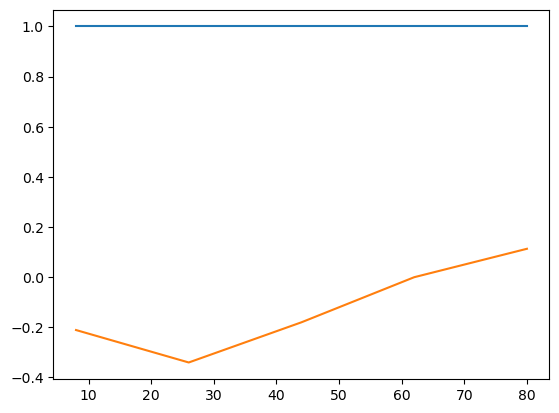

In [32]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1))
plt.plot(train_sizes_abs, test_scores.mean(axis=1))
plt.show()